In [1]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
import tensorflow as tf
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import BatchNormalization

In [2]:
import os
import skimage.io
import skimage.transform
from tqdm import tqdm
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt

In [17]:
def define_discriminator(in_shape=(224,224,3), n_classes=6):

    in_label = Input(shape=(1,))

    li = Embedding(n_classes, 50)(in_label)

    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)

    li = Reshape((in_shape[0], in_shape[1], 1))(li)

    in_image = Input(shape=in_shape)

    merge = Concatenate()([in_image, li])

    fe = Conv2D(64, (5,5), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU()(fe)
    fe = Dropout(0.3)(fe)
    
    fe = Conv2D(128, (5,5), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU()(fe)
    fe = Dropout(0.3)(fe)
    
    fe = Flatten()(fe)

    out_layer = Dense(1, activation='sigmoid')(fe)

    model = Model([in_image, in_label], out_layer)

    opt = Adam(lr=0.00001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [4]:
def define_generator(latent_dim, n_classes=6):

    in_label = Input(shape=(1,))

    li = Embedding(n_classes, 50)(in_label)

    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)

    li = Reshape((7, 7, 1))(li)

    in_lat = Input(shape=(latent_dim,))
    
    gen = Dense(7*7*256)(in_lat)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU()(gen)
    gen = Reshape((7,7,256))(gen)
    
    merge = Concatenate()([gen,li])
    
    gen = Conv2DTranspose(128, (5,5), strides = (1,1), padding='same', use_bias=False)(merge)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU()(gen)
    
    gen = Conv2DTranspose(64, (5,5), strides = (2,2), padding='same', use_bias=False)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU()(gen)
    
    gen = Conv2DTranspose(32, (5,5), strides = (2,2), padding='same', use_bias=False)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU()(gen)
    
    gen = Conv2DTranspose(16, (5,5), strides = (2,2), padding='same', use_bias=False)(gen)
    gen = BatchNormalization()(gen)
    gen = LeakyReLU()(gen)
    
    gen = Conv2DTranspose(8, (5,5), strides = (2,2), padding='same', use_bias=False)(gen)
    
    out_layer = Conv2DTranspose(3, (5,5), strides = (2,2), padding='same', use_bias=False, activation='tanh')(gen)
   
    model = Model([in_lat, in_label], out_layer)
    return model

In [18]:
def define_gan(g_model, d_model):

    d_model.trainable = False

    gen_noise, gen_label = g_model.input

    gen_output = g_model.output

    gan_output = d_model([gen_output, gen_label])

    model = Model([gen_noise, gen_label], gan_output)

    opt = Adam(lr=0.00001, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [6]:
def load_real_samples():
    
    data_dirs = [d for d in os.listdir('dreamhouse_data/')]
    
    trainX = []
    costs = []
    
    print('loading training data')
    for dd in tqdm(data_dirs):
        houses_found = [d for d in os.listdir('dreamhouse_data/'+dd) if os.path.isdir('dreamhouse_data/{}/{}'.format(dd,d))]
        with open('dreamhouse_data/{}/metadata.json'.format(dd)) as test_md:
            md = json.load(test_md)
        for house in houses_found:
            house_content = os.listdir('dreamhouse_data/{}/{}'.format(dd,house))
            if 'gsv_0.jpg' in house_content:
                try:
                    costs.append(md[house]['PRICE'])
                    path = 'dreamhouse_data/{}/{}/gsv_0.jpg'.format(dd,house)
                    x = skimage.io.imread(path)
                    x = skimage.transform.resize(x, (224,224))
                    trainX.append(x)
                except KeyError:
                    pass
    X = expand_dims(trainX,axis=-1)
    X = X.astype('float32')
    X = (X-127.5)/127.5
    
    price_df = pd.DataFrame({'costs':costs})
    bins = np.array([0,600000,1000000,1400000,1800000,2200000,float(np.Inf)])
    price_df['bin'] = pd.cut(price_df.costs,bins)
    cuts = list(set(price_df['bin'].to_list()))
    cuts = sorted(cuts)
    bin_ids = {cuts[i]:i for i in range(len(cuts))}
    price_df['cat'] = price_df['bin'].map(bin_ids)
    trainy = np.array(price_df['cat'].to_list())
    
    
    return [X, trainy]

In [7]:
def generate_real_samples(dataset, n_samples):

    images, labels = dataset

    ix = randint(0, images.shape[0], n_samples)
    
    X, labels = images[ix], labels[ix]

    y = ones((n_samples, 1))
    return [X, labels], y

In [8]:
def generate_latent_points(latent_dim, n_samples, n_classes=6):

    x_input = randn(latent_dim * n_samples)

    z_input = x_input.reshape(n_samples, latent_dim)

    labels = randint(0, n_classes, n_samples)
    return [z_input, labels]

In [9]:
def generate_fake_samples(generator, latent_dim, n_samples):

    z_input, labels_input = generate_latent_points(latent_dim, n_samples)

    images = generator.predict([z_input, labels_input])

    y = zeros((n_samples, 1))
    return [images, labels_input], y

In [10]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
    
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    for i in range(n_epochs):
        
        pbar = tqdm(range(bat_per_epo))

        for j in pbar:

            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)

            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)

            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)

            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)

            y_gan = ones((n_batch, 1))

            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            
            pbar.set_postfix({'epoch':i,'g_loss':g_loss})
            
        generate_and_save_image(g_model,i)

    g_model.save(f'cgan_generator_{n_epochs}.h5')

In [15]:
!mkdir cgan_frames_100

In [16]:
def generate_and_save_image(model,epoch):
    test_pts, labs = generate_latent_points(100,6)
    labs = np.asarray(range(6))
    X = model.predict([test_pts,labs])
    X = (X+1)/2.
    
    fig  = plt.figure()
    
    for i in range(6):
        plt.subplot(1,6,i+1)
        plt.imshow(X[i,:,:,:])
        plt.axis('off')
        
    plt.savefig('cgan_frames_100/im_at_epoch{:04d}.png'.format(epoch))
    plt.show()

In [13]:
dataset = load_real_samples()

  0%|          | 0/203 [00:00<?, ?it/s]

loading training data


100%|██████████| 203/203 [00:55<00:00,  3.66it/s]


100%|██████████| 15/15 [00:11<00:00,  1.31it/s, epoch=0, g_loss=0.597]


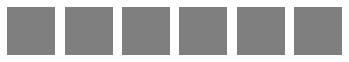

100%|██████████| 15/15 [00:09<00:00,  1.55it/s, epoch=1, g_loss=0.594]


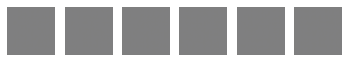

100%|██████████| 15/15 [00:09<00:00,  1.64it/s, epoch=2, g_loss=0.663]


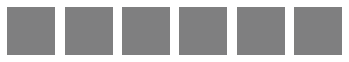

100%|██████████| 15/15 [00:09<00:00,  1.64it/s, epoch=3, g_loss=0.828]


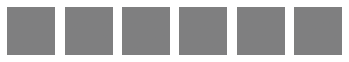

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=4, g_loss=1.1] 


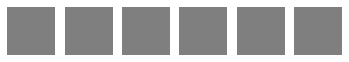

100%|██████████| 15/15 [00:09<00:00,  1.57it/s, epoch=5, g_loss=1.4] 


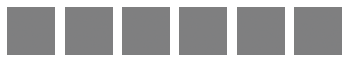

100%|██████████| 15/15 [00:09<00:00,  1.64it/s, epoch=6, g_loss=1.59]


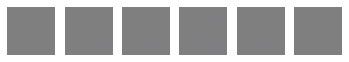

100%|██████████| 15/15 [00:09<00:00,  1.58it/s, epoch=7, g_loss=1.64]


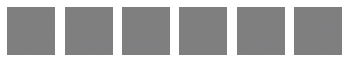

100%|██████████| 15/15 [00:09<00:00,  1.61it/s, epoch=8, g_loss=1.58]


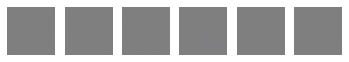

100%|██████████| 15/15 [00:09<00:00,  1.60it/s, epoch=9, g_loss=1.49]


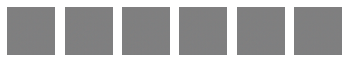

100%|██████████| 15/15 [00:09<00:00,  1.52it/s, epoch=10, g_loss=1.43]


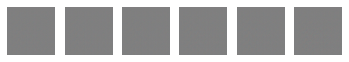

100%|██████████| 15/15 [00:09<00:00,  1.58it/s, epoch=11, g_loss=1.45]


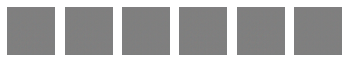

100%|██████████| 15/15 [00:09<00:00,  1.62it/s, epoch=12, g_loss=1.59]


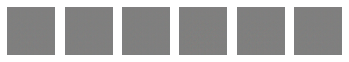

100%|██████████| 15/15 [00:09<00:00,  1.62it/s, epoch=13, g_loss=1.9] 


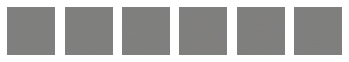

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=14, g_loss=2.38]


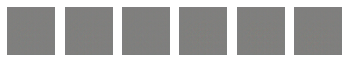

100%|██████████| 15/15 [00:09<00:00,  1.62it/s, epoch=15, g_loss=3]   


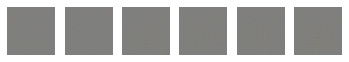

100%|██████████| 15/15 [00:09<00:00,  1.51it/s, epoch=16, g_loss=3.6] 


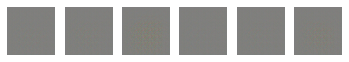

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=17, g_loss=4.19]


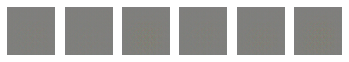

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=18, g_loss=4.57]


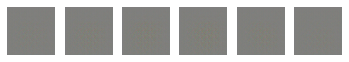

100%|██████████| 15/15 [00:09<00:00,  1.59it/s, epoch=19, g_loss=4.9] 


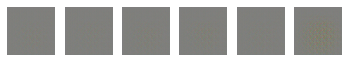

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=20, g_loss=5.1] 


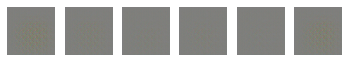

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=21, g_loss=5.21]


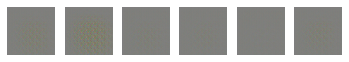

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=22, g_loss=5.42]


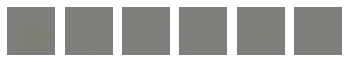

100%|██████████| 15/15 [00:09<00:00,  1.50it/s, epoch=23, g_loss=5.43]


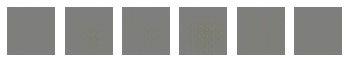

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=24, g_loss=5.61]


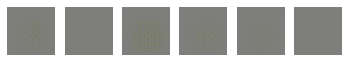

100%|██████████| 15/15 [00:09<00:00,  1.59it/s, epoch=25, g_loss=5.68]


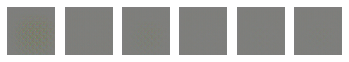

100%|██████████| 15/15 [00:09<00:00,  1.62it/s, epoch=26, g_loss=6.12]


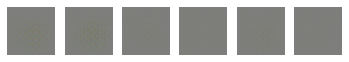

100%|██████████| 15/15 [00:09<00:00,  1.59it/s, epoch=27, g_loss=6.13]


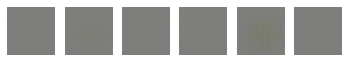

100%|██████████| 15/15 [00:09<00:00,  1.64it/s, epoch=28, g_loss=6.21]


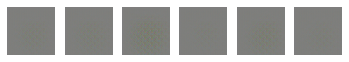

100%|██████████| 15/15 [00:09<00:00,  1.64it/s, epoch=29, g_loss=6.39]


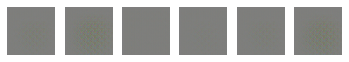

100%|██████████| 15/15 [00:09<00:00,  1.64it/s, epoch=30, g_loss=6.51]


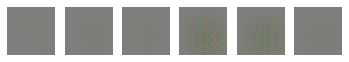

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=31, g_loss=6.56]


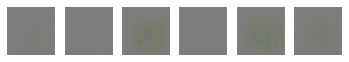

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=32, g_loss=6.68]


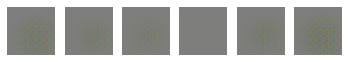

100%|██████████| 15/15 [00:09<00:00,  1.64it/s, epoch=33, g_loss=6.6] 


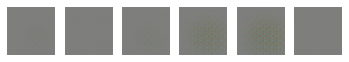

100%|██████████| 15/15 [00:09<00:00,  1.64it/s, epoch=34, g_loss=6.61]


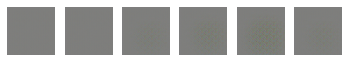

100%|██████████| 15/15 [00:09<00:00,  1.64it/s, epoch=35, g_loss=7]   


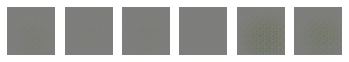

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=36, g_loss=7.08]


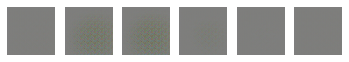

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=37, g_loss=7.12]


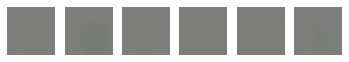

100%|██████████| 15/15 [00:09<00:00,  1.61it/s, epoch=38, g_loss=7.25]


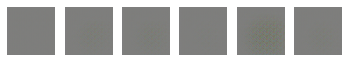

100%|██████████| 15/15 [00:09<00:00,  1.61it/s, epoch=39, g_loss=7.24]


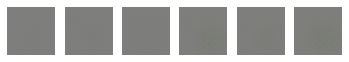

100%|██████████| 15/15 [00:09<00:00,  1.61it/s, epoch=40, g_loss=7.46]


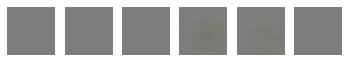

100%|██████████| 15/15 [00:09<00:00,  1.61it/s, epoch=41, g_loss=7.54]


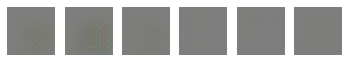

100%|██████████| 15/15 [00:09<00:00,  1.51it/s, epoch=42, g_loss=7.49]


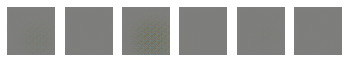

100%|██████████| 15/15 [00:09<00:00,  1.55it/s, epoch=43, g_loss=7.64]


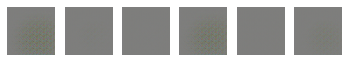

100%|██████████| 15/15 [00:09<00:00,  1.61it/s, epoch=44, g_loss=7.67]


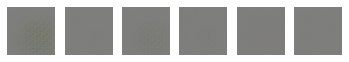

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=45, g_loss=7.78]


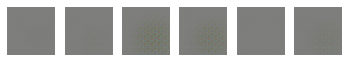

100%|██████████| 15/15 [00:09<00:00,  1.56it/s, epoch=46, g_loss=7.82]


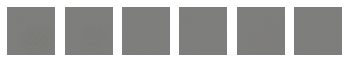

100%|██████████| 15/15 [00:09<00:00,  1.52it/s, epoch=47, g_loss=7.86]


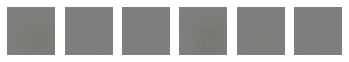

100%|██████████| 15/15 [00:09<00:00,  1.58it/s, epoch=48, g_loss=7.89]


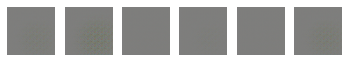

100%|██████████| 15/15 [00:09<00:00,  1.54it/s, epoch=49, g_loss=7.93]


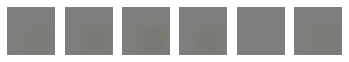

100%|██████████| 15/15 [00:09<00:00,  1.56it/s, epoch=50, g_loss=8.01]


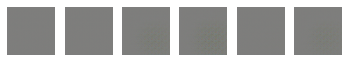

100%|██████████| 15/15 [00:09<00:00,  1.56it/s, epoch=51, g_loss=7.94]


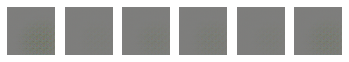

100%|██████████| 15/15 [00:09<00:00,  1.52it/s, epoch=52, g_loss=8.11]


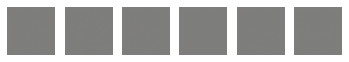

100%|██████████| 15/15 [00:09<00:00,  1.56it/s, epoch=53, g_loss=8.06]


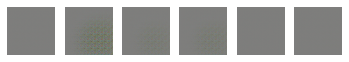

100%|██████████| 15/15 [00:09<00:00,  1.61it/s, epoch=54, g_loss=8.24]


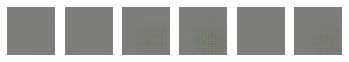

100%|██████████| 15/15 [00:09<00:00,  1.62it/s, epoch=55, g_loss=8.27]


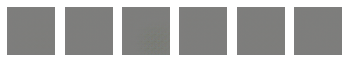

100%|██████████| 15/15 [00:09<00:00,  1.62it/s, epoch=56, g_loss=8.17]


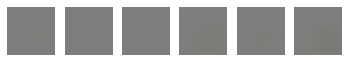

100%|██████████| 15/15 [00:10<00:00,  1.48it/s, epoch=57, g_loss=8.28]


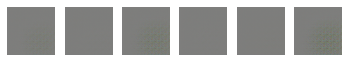

100%|██████████| 15/15 [00:09<00:00,  1.59it/s, epoch=58, g_loss=8.27]


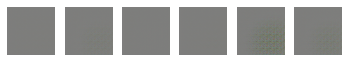

100%|██████████| 15/15 [00:09<00:00,  1.50it/s, epoch=59, g_loss=8.22]


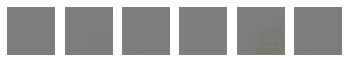

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=60, g_loss=8.36]


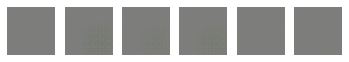

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=61, g_loss=8.46]


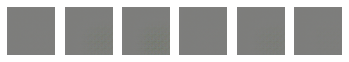

100%|██████████| 15/15 [00:09<00:00,  1.51it/s, epoch=62, g_loss=8.57]


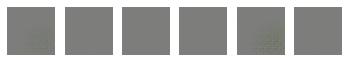

100%|██████████| 15/15 [00:09<00:00,  1.61it/s, epoch=63, g_loss=8.59]


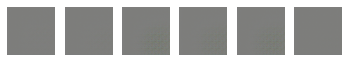

100%|██████████| 15/15 [00:09<00:00,  1.53it/s, epoch=64, g_loss=8.54]


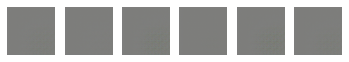

100%|██████████| 15/15 [00:09<00:00,  1.55it/s, epoch=65, g_loss=8.62]


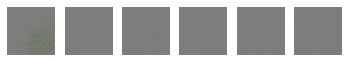

100%|██████████| 15/15 [00:09<00:00,  1.61it/s, epoch=66, g_loss=8.57]


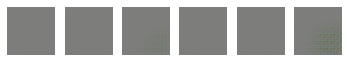

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=67, g_loss=8.74]


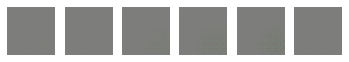

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=68, g_loss=8.69]


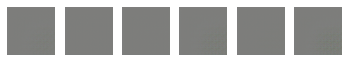

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=69, g_loss=8.82]


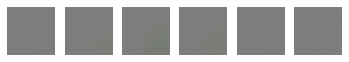

100%|██████████| 15/15 [00:09<00:00,  1.61it/s, epoch=70, g_loss=8.82]


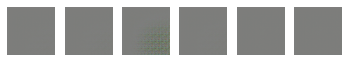

100%|██████████| 15/15 [00:09<00:00,  1.55it/s, epoch=71, g_loss=8.86]


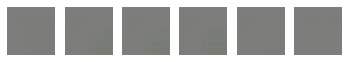

100%|██████████| 15/15 [00:09<00:00,  1.60it/s, epoch=72, g_loss=8.88]


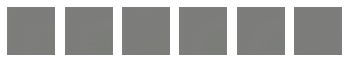

100%|██████████| 15/15 [00:10<00:00,  1.47it/s, epoch=73, g_loss=8.88]


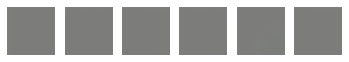

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=74, g_loss=8.9] 


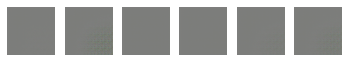

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=75, g_loss=8.94]


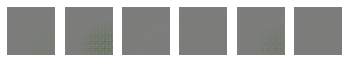

100%|██████████| 15/15 [00:09<00:00,  1.52it/s, epoch=76, g_loss=9]   


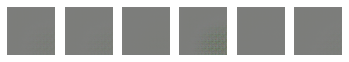

100%|██████████| 15/15 [00:09<00:00,  1.61it/s, epoch=77, g_loss=9.01]


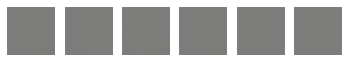

100%|██████████| 15/15 [00:09<00:00,  1.57it/s, epoch=78, g_loss=9.08]


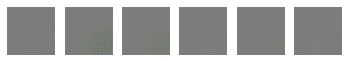

100%|██████████| 15/15 [00:09<00:00,  1.51it/s, epoch=79, g_loss=9.07]


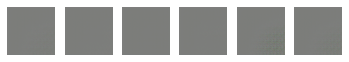

100%|██████████| 15/15 [00:09<00:00,  1.60it/s, epoch=80, g_loss=9.08]


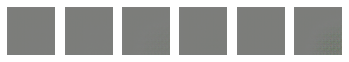

100%|██████████| 15/15 [00:09<00:00,  1.56it/s, epoch=81, g_loss=9.11]


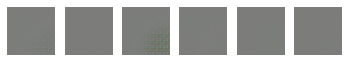

100%|██████████| 15/15 [00:09<00:00,  1.51it/s, epoch=82, g_loss=9.13]


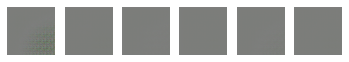

100%|██████████| 15/15 [00:09<00:00,  1.61it/s, epoch=83, g_loss=9.16]


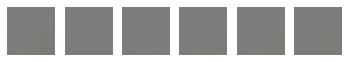

100%|██████████| 15/15 [00:09<00:00,  1.62it/s, epoch=84, g_loss=9.2] 


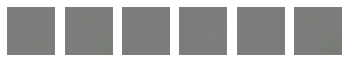

100%|██████████| 15/15 [00:09<00:00,  1.62it/s, epoch=85, g_loss=9.21]


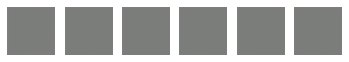

100%|██████████| 15/15 [00:09<00:00,  1.62it/s, epoch=86, g_loss=9.26]


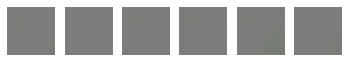

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=87, g_loss=9.25]


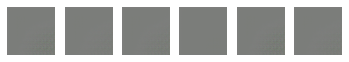

100%|██████████| 15/15 [00:10<00:00,  1.49it/s, epoch=88, g_loss=9.25]


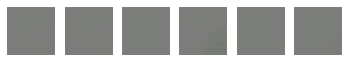

100%|██████████| 15/15 [00:09<00:00,  1.63it/s, epoch=89, g_loss=9.27]


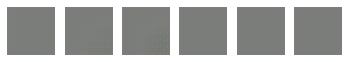

100%|██████████| 15/15 [00:09<00:00,  1.55it/s, epoch=90, g_loss=9.32]


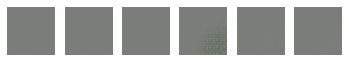

100%|██████████| 15/15 [00:09<00:00,  1.50it/s, epoch=91, g_loss=9.32]


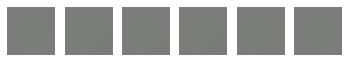

100%|██████████| 15/15 [00:09<00:00,  1.59it/s, epoch=92, g_loss=9.37]


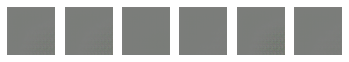

100%|██████████| 15/15 [00:09<00:00,  1.56it/s, epoch=93, g_loss=9.39]


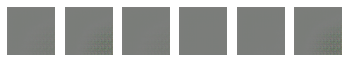

100%|██████████| 15/15 [00:09<00:00,  1.57it/s, epoch=94, g_loss=9.4] 


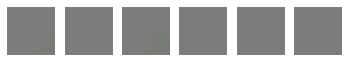

100%|██████████| 15/15 [00:09<00:00,  1.51it/s, epoch=95, g_loss=9.4] 


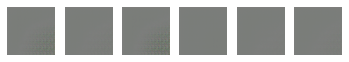

100%|██████████| 15/15 [00:10<00:00,  1.49it/s, epoch=96, g_loss=9.43]


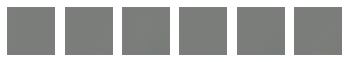

100%|██████████| 15/15 [00:09<00:00,  1.51it/s, epoch=97, g_loss=9.44]


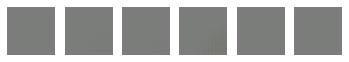

100%|██████████| 15/15 [00:09<00:00,  1.57it/s, epoch=98, g_loss=9.46]


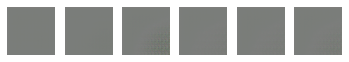

100%|██████████| 15/15 [00:09<00:00,  1.64it/s, epoch=99, g_loss=9.49]


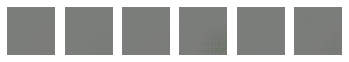

In [19]:
latent_dim = 100

d_model = define_discriminator()

g_model = define_generator(latent_dim)

gan_model = define_gan(g_model, d_model)

train(g_model, d_model, gan_model, dataset, latent_dim,n_epochs=100)